In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
try:
    from sklearn.datasets.samples_generator import make_blobs
except ImportError:
    from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import os

In [2]:
# task2vec_multi: copy tasks for demonstrataion and visualisation?

def generate_vec(data, dic, norm, mode=1, split='/', e=1):
    terms = data.split(split)
    vec = np.zeros(len(dic)).astype(int)
    for t in terms: # here t is the ontology classes
        weighted_idx = dic[t]
        if isinstance(weighted_idx, int): 
            vec[weighted_idx] = 1
        else:          
            vec[weighted_idx[0]] = e * weighted_idx[1]

    if norm==True:
        vec = normalization(vec, mode)
    #print(terms, '\t', vec)
    return vec

def normalization(data, mode=1):
    if mode==1:
        mu = np.mean(data, axis=0)
        sigma = np.std(data, axis=0)
        return (data - mu) / sigma
    else:
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range


In [3]:
root = os.getcwd()
print('current base file: ', root)
work_data = os.path.join(root, 'data/task2vec_10.csv')
data_work_df = pd.read_csv(work_data, header=0)
sample_num = data_work_df.shape[0]
print('there are {} data samples'.format(sample_num))

current base file:  /Users/wuchengke/Documents/Other Study/Jupyter/LDA
there are 10 data samples


In [4]:
weigthed = False
norm = True

if weigthed==True:
    map_dic_sp = {'None':[0,10], 'Space':[1,4], 'Plane':[2,4], 'Storey':[3,4], 'H_plane':[4,3], 'V_plane':[5,3], 'Ceil':[6,2],
                  'Wall':[7,2], 'Roof':[8,2], 'Floor':[9,2], 'Room_level_space':[10,3], 'Story_level_space':[11,3], 'Building_level_space':[12,3]}
    map_dic_it = {'None':[0,10], 'MEP_opening':[1,3], 'Door':[2,3], 'Window':[3,3], 'Interface':[4,4]}
    map_dic_mer = {'None':[0,10], 'Product':[1,4], 'Material':[2,3], 'Furniture':[3,2], 'Member':[4,3], 'Board':[5,1], 'MEP_Good':[6,2],
                  'Other_Good':[7,2], 'Door':[8,1], 'Window':[9,1], 'Steel_Material':[10,2], 'Welding_Material':[11,2], 'Painting_Material':[12,2],
                  'Concrete_Material':[13,2], 'Stud':[14,1], 'Insulation_Material':[15,2], 'MEP_Member':[16,2]}
    map_dic_lr = {'None':[0,10], 'WL':[1,1], 'PT':[2,1], 'PL':[3,1], 'TL':[4,1], 'CL':[5,1], 'RL':[6,1]} # None here means normal labour
else:
    map_dic_sp = {'None':0, 'Space':1, 'Plane':2, 'Storey':3, 'H_plane':4, 'V_plane':5, 'Ceil':6, 'Wall':7, 'Roof':8, 'Floor':9, 
                  'Room_level_space':10, 'Story_level_space':11, 'Building_level_space':12}
    map_dic_it = {'None':0, 'MEP_opening':1, 'Door':2, 'Window':3, 'Interface':4}
    map_dic_mer = {'None':0, 'Product':1, 'Material':2, 'Furniture':3, 'Member':4, 'Board':5, 'MEP_Good':6,
                  'Other_Good':7, 'Door':8, 'Window':9, 'Steel_Material':10, 'Welding_Material':11, 'Painting_Material':12,
                  'Concrete_Material':13, 'Stud':14, 'Insulation_Material':15, 'MEP_Member':16}
    map_dic_lr = {'None':0, 'WL':1, 'PT':2, 'PL':3, 'TL':4, 'CL':5, 'RL':6} # None here means normal labour

map_dic = {'SP':map_dic_sp, 'IT':map_dic_it, 'MER':map_dic_mer, 'LR':map_dic_lr}
#map_dic = {'SP':map_dic_sp, 'MER':map_dic_mer, 'LR':map_dic_lr}

In [17]:
temp_data_list = []

#for k, m in map_dic.items():
#    print('processing feature: ', k)
#    current_map = map_dic[k]
#    temp_data = np.zeros((sample_num, len(current_map)))
#    values = data_work_df[k].values
#    
#    for i in range(sample_num):
#        # here we normalise features other than task dependencies, as they can produce unrealistic results
#        # e.g., two tasks separated by many tasks are packaged together
#        temp_vec = generate_vec(data_work_df[k].values[i], current_map, norm)
#        temp_data[i] = temp_vec
#    temp_data_list.append(temp_data)

In [18]:
# compute preceding and succeeding task as additional feature
print('processing feature: Task')
pre_data_temp = [a.split(',') for a in data_work_df['PRE'].values]
suc_data = list(data_work_df['SUC'].values)

pre_data = []
for p_data in pre_data_temp:
    pre_data.append(np.average(list(map(int, p_data))))

dep_vec = np.zeros((len(pre_data), 2))
for i in range(len(dep_vec)):
    dep_vec[i][0] = pre_data[i]
    dep_vec[i][1] = suc_data[i]

# NOTE here we do not normalise dependency to increase its weight
norm = False
if norm==True:
    temp_data_list.append(normalization(dep_vec))
else:
    temp_data_list.append(dep_vec)

# 拼接矩阵
# Feature sequence: SP, IT, MER, LR, TASK
data_k = np.hstack(temp_data_list)
print('The data for k-means: ', data_k.shape)
print('An example of the task vector: ', data_k[0])

processing feature: Task
The data for k-means:  (10, 2)
An example of the task vector:  [0. 2.]


### 结合手肘法和Gap-statistics寻找最佳K

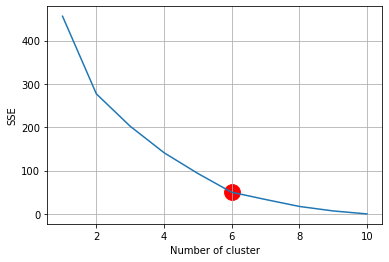

In [8]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k).fit(data_k)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.grid(True)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.scatter(6, sse[6], s=250, c='r')
fig_path1 = os.path.join(root, 'elbow.jpg')
plt.savefig(fig_path1, dpi=400) 
plt.show()

In [14]:
from collections import Counter

optimalK = OptimalK(parallel_backend='rust')
#opt_clist = []

while(True):
    n_clusters = optimalK(data_k, cluster_array=np.arange(1, 10)) # the algorithm returns a single int value for the number of clusters
    #opt_clist.append(n_clusters)
    if n_clusters==10:
        break

plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')

fig_path2 = os.path.join(root, 'gap_statistic.jpg')
plt.savefig(fig_path2, dpi=400) 
plt.show()

ModuleNotFoundError: No module named 'gapstat_rs'

### 从两方面分析，综合结果取K=10

### 测试 hierarchical clustering 效果

In [19]:
from sklearn.cluster import AgglomerativeClustering
h_model = AgglomerativeClustering(n_clusters=5)
h_model.fit(data_k)
df = pd.DataFrame(data_k)
df['task_name'] = data_work_df['Task detail']
df['package'] = h_model.labels_
df[:10]


,0,1,task_name,package
0,0.0,2.0,Board pretreatment and punching,4
1,1.0,4.0,2D panel assembly,0
2,1.0,4.0,Butt weld and fillet weld,0
3,2.5,5.0,3D assembly,0
4,4.0,6.0,Apply fire paint at strucutral member,3
5,5.0,7.0,Rebar Fixing,3
6,6.0,8.0,Pouring and curing Concrete,1
7,7.0,9.0,Door and window frame installation,1
8,8.0,10.0,Stud installation at ceiling,2
9,9.0,11.0,Stud installation at wall,2


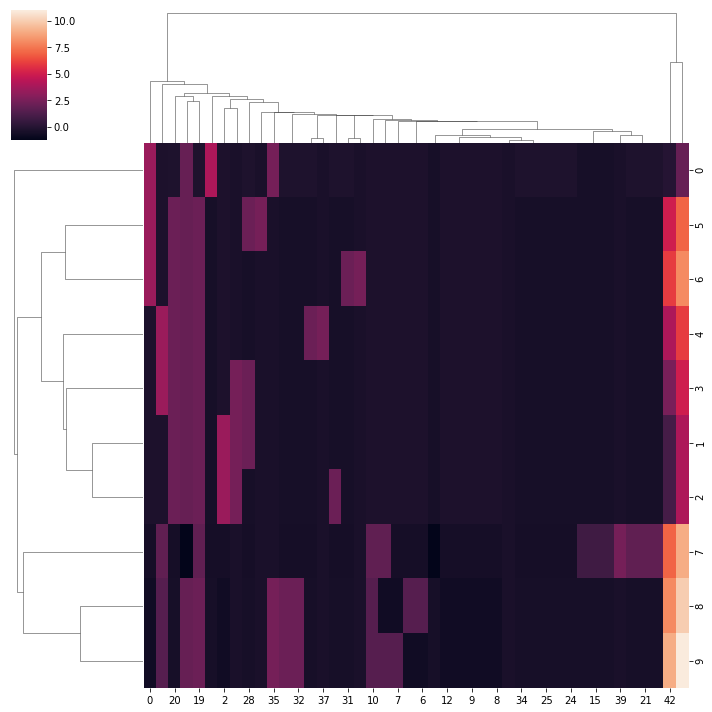

In [36]:
import seaborn as sns

fig_path6 = os.path.join(root, 'heat_10.jpg')
cmap = sns.clustermap(data_k, method='single', metric='euclidean')

plt.savefig(fig_path6, dpi=400)
plt.show()

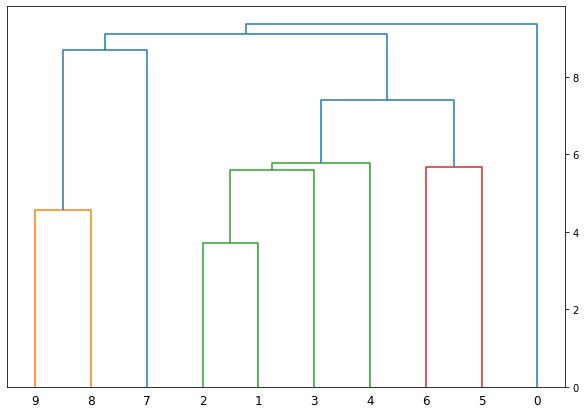

In [37]:
import scipy.cluster.hierarchy as sch

label_lst = range(0,10)
ss = sch.linkage(data_k, method='single')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
sch.dendrogram(ss, labels=label_lst, distance_sort='descending', show_leaf_counts=True)
ax.yaxis.tick_right()

fig_path5 = os.path.join(root, 'hier_10.jpg')
plt.savefig(fig_path5, dpi=400)
plt.show()

### 使用最佳的K运行K-means

In [57]:
km = KMeans(10)
km.fit(data_k)
km.labels_[:33]

df = pd.DataFrame(data_k)
df['task_name'] = data_work_df['Task detail']
df['package'] = km.labels_
df[:33]

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,task_name,package
0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,Board pretreatment and punching,4
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2D panel assembly,2
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,Butt weld and fillet weld,2
3,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.5,5.0,3D assembly,2
4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,Apply fire paint at strucutral member,2
5,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,7.0,Rebar Fixing,6
6,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,6.0,8.0,Pouring and curing Concrete,6
7,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,7.0,9.0,Door and window frame installation,7
8,0.0,4.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,10.0,Stud installation at ceiling,0
9,0.0,4.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,11.0,Stud installation at wall,0


### 测试阶段：
### 363条task数据 使用K-means聚类并结合PCA对K-means结合可视化

In [58]:
df_show = df.loc[:, list(np.arange(0, 42))]
df_show['label'] = df['package']

In [59]:
def pca(dataMat, topNfeat=999999):
    meanVals = np.mean(dataMat, axis=0)
    DataAdjust = dataMat - meanVals           #减去平均值
    covMat = np.cov(DataAdjust, rowvar=0)
    eigVals,eigVects = np.linalg.eig(np.mat(covMat)) #计算特征值和特征向量
    #print eigVals
    eigValInd = np.argsort(eigVals)
    eigValInd = eigValInd[:-(topNfeat+1):-1]   #保留最大的前K个特征值
    redEigVects = eigVects[:,eigValInd]        #对应的特征向量
    lowDDataMat = DataAdjust * redEigVects     #将数据转换到低维新空间
    reconMat = (lowDDataMat * redEigVects.T) + meanVals   #重构数据，用于调试
    return lowDDataMat, reconMat

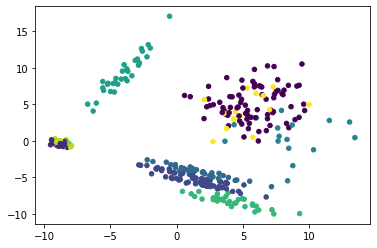

In [61]:
# randomly corrput the features (e.g., delete the leaf classes, randonly delete a single feature,
# such as its labour resources or preceding task)

x = np.array(df_show.iloc[:,0:-1])
rand = np.random.normal(1, 0.25, (x.shape[0], x.shape[1]))
x = x * rand

lowDMat, reconMat = pca(x, 2)
data_pca = np.real(lowDMat.A) # 2d
plt.scatter(data_pca[:,0], data_pca[:,1], s=20, c=df_show.label.values)

fig_path3 = os.path.join(root, 'clusters.jpg')
plt.savefig(fig_path3, dpi=400)
plt.show()

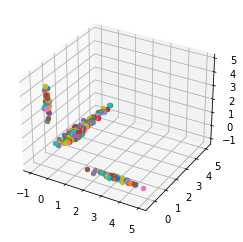

In [29]:
# 3D可视化(效果不好)
ax = plt.subplot(projection='3d')
for p in range(0, sample_num):
    y = df_show.label.values[p]
    ax.scatter((x[p, 0]), (x[p, 1]), (x[p, 2]))
plt.show()

In [53]:
s_score = silhouette_score(df_show.iloc[:,0:-1], km.labels_)
print('silhouette score:', s_score)

c_score = calinski_harabasz_score(df_show.iloc[:,0:-1], km.labels_)
print('calinski_harabaz_score score:', c_score)

silhouette score: 0.4397076819645843
calinski_harabaz_score score: 97.19613526570046


In [60]:
s_score = silhouette_score(df_show.iloc[:,0:-1], km.labels_)
print('silhouette score:', s_score)

c_score = calinski_harabasz_score(df_show.iloc[:,0:-1], km.labels_)
print('calinski_harabaz_score score:', c_score)

silhouette score: 0.5692888444439135
calinski_harabaz_score score: 487.6601602859456


In [47]:
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score

s_score = silhouette_score(df_show.iloc[:,0:-1], km.labels_)
print('silhouette score:', s_score)

c_score = calinski_harabasz_score(df_show.iloc[:,0:-1], km.labels_)
print('calinski_harabaz_score score:', c_score)

silhouette score: 0.4510751184396096
calinski_harabaz_score score: 135.855628535327


In [31]:
for i in range(2,20):    
    kmeans = KMeans(n_clusters=i, random_state=123).fit(df_show.iloc[:,0:-1])    
    score = calinski_harabasz_score(df_show.iloc[:,0:-1], kmeans.labels_)    
    print('聚类%d簇的calinski_harabaz分数为：%f'%(i,score))

聚类2簇的calinski_harabaz分数为：108.599667
聚类3簇的calinski_harabaz分数为：116.211613
聚类4簇的calinski_harabaz分数为：123.754250
聚类5簇的calinski_harabaz分数为：131.854248
聚类6簇的calinski_harabaz分数为：155.095129
聚类7簇的calinski_harabaz分数为：170.332216
聚类8簇的calinski_harabaz分数为：190.926299
聚类9簇的calinski_harabaz分数为：229.552654
聚类10簇的calinski_harabaz分数为：265.139005
聚类11簇的calinski_harabaz分数为：313.143458
聚类12簇的calinski_harabaz分数为：384.071127
聚类13簇的calinski_harabaz分数为：477.465087
聚类14簇的calinski_harabaz分数为：548.935620
聚类15簇的calinski_harabaz分数为：657.260695
聚类16簇的calinski_harabaz分数为：817.887876
聚类17簇的calinski_harabaz分数为：1126.257622
聚类18簇的calinski_harabaz分数为：1787.319260
聚类19簇的calinski_harabaz分数为：2994.005677


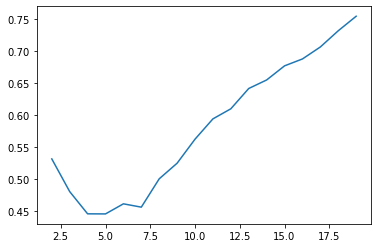

In [119]:
silhouettescore=[] 
for i in range(2,20):      
    kmeans=KMeans(n_clusters=i, random_state=123).fit(df_show.iloc[:,0:-1])      
    score=silhouette_score(df_show.iloc[:,0:-1], kmeans.labels_)
    silhouettescore.append(score)
    
plt.plot(range(2, 20),silhouettescore,linewidth=1.5,linestyle='-')
plt.show()

In [ ]:
# for demonstration
values = data_work_df['MER'].values
test = values[1]
generate_vec(test, map_dic_mer, False)

print('\n')
test = values[0]
generate_vec(test, map_dic_mer, False)

for i in range(50):
    n_clusters = optimalK(data_k, cluster_array=np.arange(1, 11)) # the algorithm returns a single int value for the number of clusters
    opt_clist.append(n_clusters)
    
collects = Counter(opt_clist)
most = collects.most_common(1)
print('Optimal clusters: ', most)
print(collects)

plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()